In [360]:
import glob
import numpy as np
import scipy as sp
import einops as eo
import matplotlib.pyplot as plt
import math
from scipy.spatial.transform import Rotation

M0 = 1480 #mT
shape = [3*25.4/16, 25.4/8] #radius and height
x0 = np.array([0,0,10, 0,0,1])


In [361]:
def B_dipole(position, rotation, M0, shape):
    R = np.sqrt(np.sum(position**2, axis=1))
    B = (M0 * (shape[0]) ** 2 * shape[1] / (16)) * (
        (
            3
            * position
            / R[:, np.newaxis] ** 5
            * (eo.einsum(position, rotation, "sensor dim,  dim -> sensor"))[
                :, np.newaxis
            ]
        )
        - rotation[np.newaxis, :] / (R[:, np.newaxis] ** 3)
    )
    return B


def getField_dipole(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def getField_dipole_fixed(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def cost_dipole(x, B, positions, M0, shape):
    diff = getField_dipole(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)


def minimize(x0, B, positions, M0, shape, *args):
    #print("Starting mimimization")
    b_args = (B, positions, M0, shape)
    cons = [{"type": "eq", "fun": lambda x: x[3] ** 2 + x[4] ** 2 + x[5] ** 2 - 1}]
    bounds = [(-100, 100), (-100, 100), (0, 100), (-1, 1), (-1, 1), (-1, 1)]
    res = sp.optimize.minimize(
        fun=cost_dipole, x0=x0, args=b_args, tol=1e-100, constraints=cons, bounds=bounds, *args
    ).x  
    #print(f"Finished mimimization with shape {b_args[3]} at {res}")
    return res

def circle_radius(x1, y1, x2, y2, x3, y3):
    # Calculate lengths of sides of the triangle formed by the three points
    a = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    b = math.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)
    c = math.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    area = math.sqrt(s * (s - a) * (s - b) * (s - c))

    # Calculate the radius of the circle using the formula: radius = (abc) / (4 * area)
    radius = (a * b * c) / (4 * area)
    
    return radius

In [362]:
folder = r"C:\Users\Brandon Nguyen\Documents\Github\magnetic-sensor-data\MLX06062024_isocenter_angle"
file_list = sorted(glob.glob(f'{folder}/*.npz'))
len(file_list)
data = np.load(file_list[0])
pos = data['pos'][0]

In [363]:
loc_pred = [np.array([0,0,0])]
angle_pred = [np.array([0,0,0])]
B_stdev = [np.array(pos)]
for x in range(len(file_list)):
    data = np.load(file_list[x])
    mags = data['mags']
    pos = data['pos'][0]
    B = np.mean(mags, axis=0)
    mags_stdev = np.std(mags, axis=0)
    x_res = minimize(x0, B, pos, M0, shape)
    loc_pred = np.append(loc_pred, [x_res[0:3]], axis=0)
    angle_pred = np.append(angle_pred, [x_res[3:6]], axis=0)
    B_stdev = np.append(B_stdev, [mags_stdev], axis=0)
loc_pred = np.delete(loc_pred, 0, axis=0)
angle_pred = np.delete(angle_pred, 0, axis=0)
B_stdev = np.delete(B_stdev, 0 ,axis=0)

In [364]:
np.append(loc_pred, angle_pred, axis=1)
#np.sum(angle_pred**2)

array([[-5.77252857e-01,  9.15859391e-01,  1.94626434e+01,
        -1.90608240e-01,  1.87163596e-01,  9.63658802e-01],
       [-6.39256784e-01,  8.59159443e-01,  1.94763753e+01,
        -2.02350140e-01,  1.45228037e-01,  9.68485022e-01],
       [-7.10423136e-01,  8.64088479e-01,  1.94949762e+01,
        -2.14514726e-01,  1.07610445e-01,  9.70774652e-01],
       [-2.10031504e+00, -1.39236691e+00,  1.93207372e+01,
        -3.86640249e-01, -2.46263016e-01,  9.16028634e-01],
       [-8.48266544e-01,  7.49836274e-01,  1.95156672e+01,
        -2.39026553e-01,  1.87616920e-02,  9.70831760e-01],
       [-5.92444106e-01,  9.82390020e-01,  1.94910838e+01,
        -1.58045676e-01,  2.01648491e-01,  9.66622703e-01],
       [-6.61651331e-01,  9.64634212e-01,  1.95086910e+01,
        -1.70464813e-01,  1.63352191e-01,  9.71729288e-01],
       [-7.11483723e-01,  9.36807936e-01,  1.95267273e+01,
        -1.80195507e-01,  1.25435059e-01,  9.75600136e-01],
       [-7.98284475e-01,  8.99169991e-01,  1.954

In [365]:
def constfunc(const):
    actang = [np.array([0, 0, 0])]
    for y in range(5):
        for x in range(5):
            R = Rotation.from_euler('ZYX' ,np.array([0, 2*y-4, 2*x-4])-const, degrees=True)
            norm = np.array([[0, 0, 1]])
            rotated = R.apply(norm, inverse=False)[0]
            #add = np.array([np.sin(np.deg2rad(2*y-4)), -np.sin(np.deg2rad(2*x-4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*x-4))])
            actang = np.append(actang, [rotated], axis=0)
    actang = np.delete(actang, 0, axis=0)
    cost = np.sum((angle_pred-actang)**2)
    return cost

res= sp.optimize.minimize(constfunc, x0=np.array([0,0,0]))
shift = res.x
print(res)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.1678421493585922
        x: [-8.031e+00  7.813e+00  8.277e+00]
      nit: 25
      jac: [-4.973e-07 -4.537e-06 -2.783e-06]
 hess_inv: [[ 8.801e+03  1.243e+03 -1.249e+03]
            [ 1.243e+03  2.324e+02 -1.716e+02]
            [-1.249e+03 -1.716e+02  2.370e+02]]
     nfev: 116
     njev: 29


In [366]:
actang = [np.array([0, 0, 0])]
const = shift
for y in range(5):
    for x in range(5):
        R = Rotation.from_euler('ZYX' ,np.array([0, 2*y-4, 2*x-4])-const, degrees=True)
        norm = np.array([[0, 0, 1]])
        rotated = R.apply(norm, inverse=False)[0]
        #add = np.array([np.sin(np.deg2rad(2*y-4)), -np.sin(np.deg2rad(2*x-4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*x-4))])
        actang = np.append(actang, [rotated], axis=0)
actang = np.delete(actang, 0, axis=0)
locact = actang*2
np.sum(actang**2)
print(actang)

[[-0.22778513  0.18261431  0.95643397]
 [-0.22438659  0.14852393  0.96311541]
 [-0.22071467  0.11425259  0.96862345]
 [-0.21677385  0.07984206  0.97295136]
 [-0.21256891  0.04533424  0.97609388]
 [-0.19461275  0.1872946   0.9628326 ]
 [-0.19098248  0.15323691  0.96955874]
 [-0.18711952  0.11899253  0.97510362]
 [-0.18302859  0.08460317  0.97946048]
 [-0.17871466  0.05011074  0.98262403]
 [-0.16123946  0.19200323  0.96805816]
 [-0.15737605  0.15797844  0.9748208 ]
 [-0.1533209   0.12376117  0.98039577]
 [-0.14907895  0.08939312  0.98477629]
 [-0.14465537  0.05491616  0.987957  ]
 [-0.12770592  0.19673448  0.97210429]
 [-0.12360825  0.16274273  0.9788952 ]
 [-0.11935998  0.12855271  0.98449347]
 [-0.11496629  0.09420607  0.98889229]
 [-0.11043253  0.05974465  0.9920863 ]
 [-0.09405298  0.20148256  0.97496606]
 [-0.08972022  0.16752399  0.98177696]
 [-0.08527815  0.13336131  0.98739171]
 [-0.08073218  0.09903616  0.99180349]
 [-0.07608785  0.06459034  0.9950069 ]]


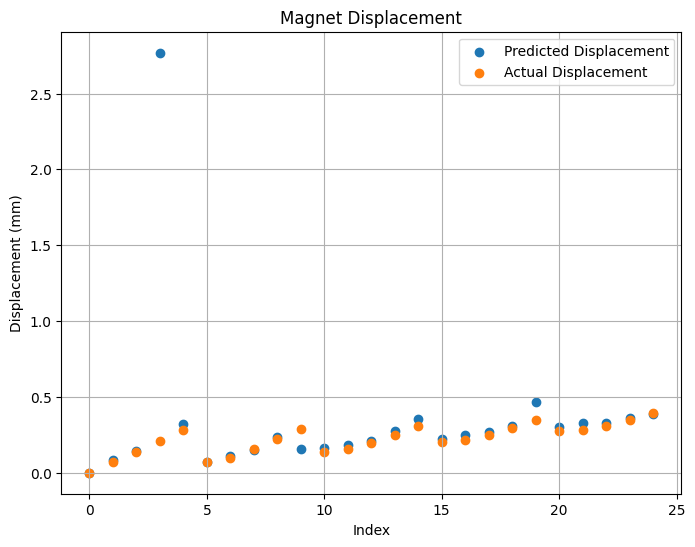

[ 0.         -0.06200393 -0.13317028 -1.52306218 -0.27101369 -0.01519125
 -0.08439847 -0.13423087 -0.22103162 -0.09857094 -0.0242732  -0.08390863
 -0.14799385 -0.2311405  -0.3237528  -0.02015217 -0.0853592  -0.14580811
 -0.21423946 -0.30274969 -0.00944135 -0.06835271 -0.12925025 -0.18508225
 -0.26563361]
[ 0.         -0.05669995 -0.05177091 -2.3082263  -0.16602312  0.06653063
  0.04877482  0.02094855 -0.0166894   0.06586899  0.1507967   0.14481191
  0.10526456  0.08489361  0.03212888  0.20161924  0.20422133  0.18602579
  0.15691007 -0.31088293  0.28202033  0.29119936  0.25321967  0.24475579
  0.17685483]
[ 0.          0.01373184  0.03233279 -0.14190624  0.05302377  0.02844033
  0.0460476   0.06408384  0.08160179  0.10644802  0.05675716  0.07929659
  0.09871472  0.12137893  0.14267774  0.08464655  0.10909996  0.13276522
  0.15573473  0.17656937  0.10732082  0.13690856  0.16568192  0.19521923
  0.21853307]
[0.         0.0851348  0.14649218 2.76907285 0.32221672 0.07393207
 0.10780755 0.1

In [367]:
dispx = np.array(loc_pred[:,0]-loc_pred[:,0][0])
dispy = np.array(loc_pred[:,1]-loc_pred[:,1][0])
dispz = np.array(loc_pred[:,2]-loc_pred[:,2][0])
disp = np.sqrt(dispx**2+dispy**2+dispz**2)
actdispx = np.array(locact[:,0]-locact[:,0][0])
actdispy = np.array(locact[:,1]-locact[:,1][0])
actdispz = np.array(locact[:,2]-locact[:,2][0])
actdisp = np.sqrt(actdispx**2+actdispy**2+actdispz**2)

plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(disp))), disp, label='Predicted Displacement')
plt.scatter(list(range(len(actdisp))), actdisp, label='Actual Displacement')
plt.xlabel('Index')
plt.ylabel('Displacement (mm)')
plt.title('Magnet Displacement')
plt.legend()
plt.grid(True)
plt.show()

print(dispx)
print(dispy)
print(dispz)
print(disp)

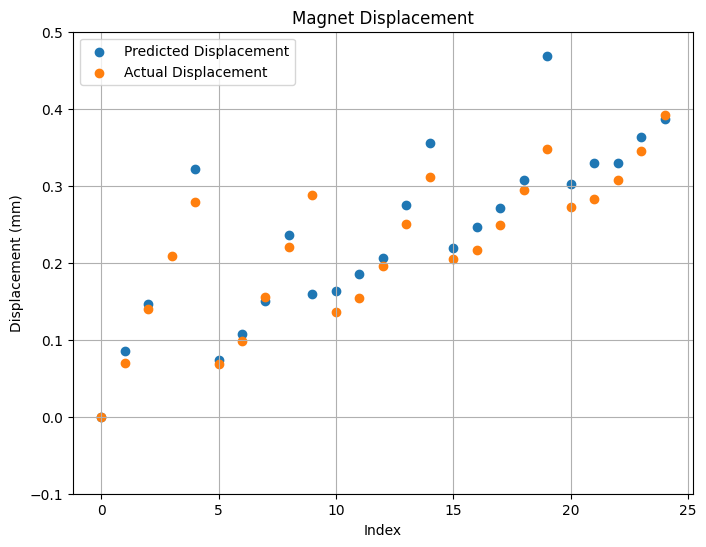

In [368]:
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(disp))), disp, label='Predicted Displacement')
plt.scatter(list(range(len(actdisp))), actdisp, label='Actual Displacement')
plt.xlabel('Index')
plt.ylabel('Displacement (mm)')
plt.title('Magnet Displacement')
plt.legend()
plt.ylim([-0.1,0.5])
plt.grid(True)
plt.show()

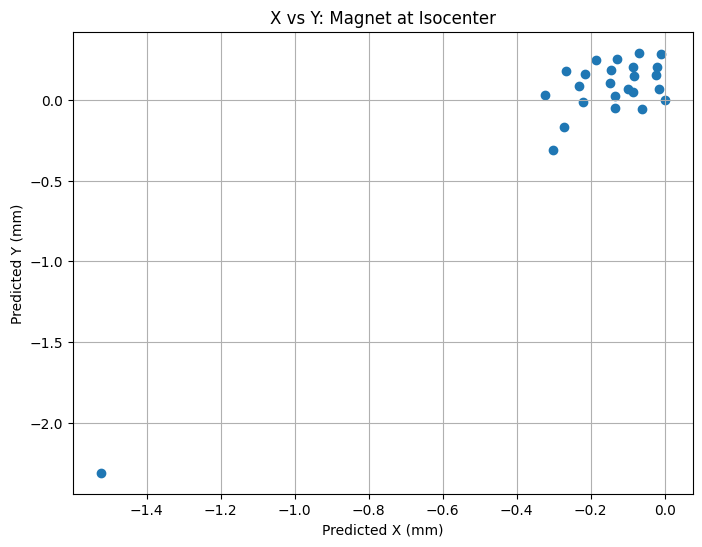

In [369]:
plt.figure(figsize=(8, 6))
plt.scatter(dispx, dispy, label='Predicted Location')
plt.xlabel('Predicted X (mm)')
plt.ylabel('Predicted Y (mm)')
plt.title('X vs Y: Magnet at Isocenter')
#plt.legend()
plt.grid(True)
plt.show()

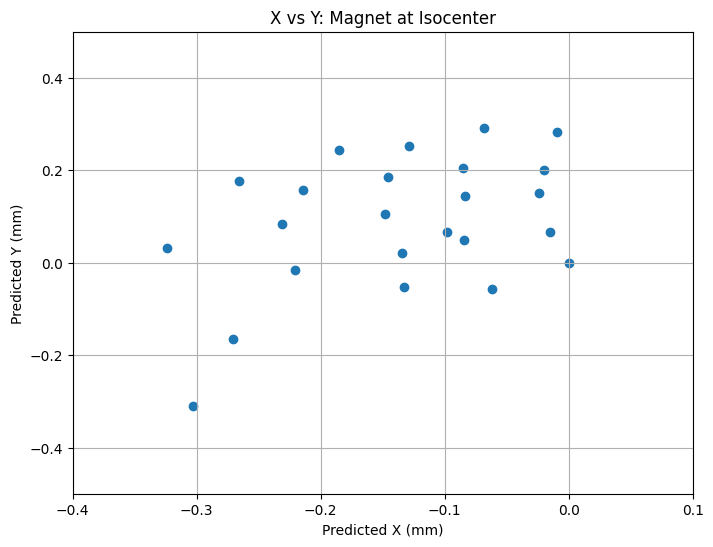

In [370]:
plt.figure(figsize=(8, 6))
plt.scatter(dispx, dispy, label='Predicted Location')
plt.xlabel('Predicted X (mm)')
plt.ylabel('Predicted Y (mm)')
plt.title('X vs Y: Magnet at Isocenter')
plt.xlim([-0.4,0.1])
plt.ylim([-0.5, 0.5])
#plt.legend()
plt.grid(True)
plt.show()

In [371]:
x1, z1 = loc_pred[5,0], loc_pred[5,2]
x2, z2 = loc_pred[10,0], loc_pred[10,2]
x3, z3 = loc_pred[15,0], loc_pred[15,2]
print("Radius of the circle about the x-axis:", circle_radius(x1, z1, x2, z2, x3, z3))

y1, z21 = loc_pred[5,1], loc_pred[5,2]
y2, z22 = loc_pred[7,1], loc_pred[7,2]
y3, z23 = loc_pred[9,1], loc_pred[9,2]
print("Radius of the circle about the y-axis:", circle_radius(y1, z21, y2, z22, y3, z23))

Radius of the circle about the x-axis: 0.06392797184762394
Radius of the circle about the y-axis: 0.03945437680808237


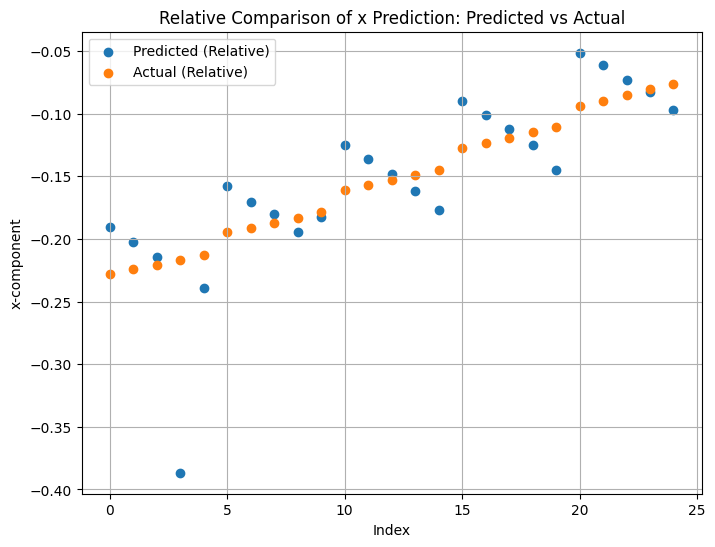

In [372]:
rel_locactx = [x-locact[0,0] for x in locact[:,0]]
rel_loc_predx = [x - loc_pred[0,0] for x in loc_pred[:,0]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(angle_pred[:,0]))), angle_pred[:,0], label='Predicted (Relative)')
plt.scatter(list(range(len(actang[:,0]))), actang[:,0], label='Actual (Relative)')
plt.xlabel('Index')
plt.ylabel('x-component')
plt.title('Relative Comparison of x Prediction: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

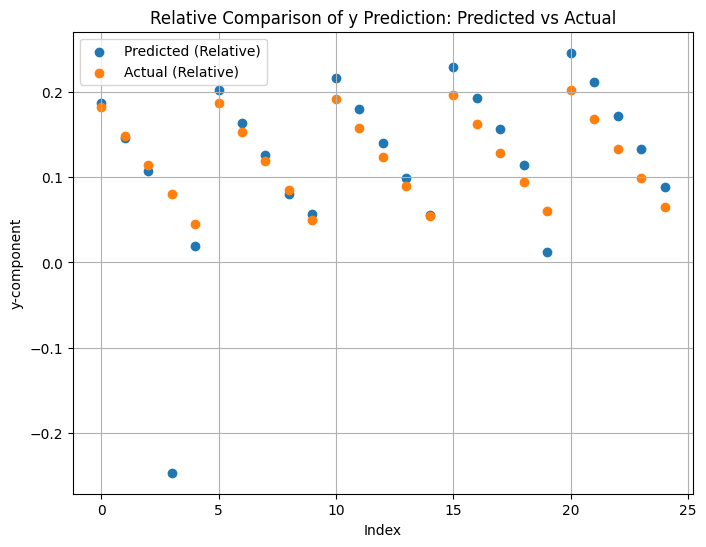

In [373]:
rel_locacty = [x-locact[0,1] for x in locact[:,1]]
rel_loc_predy = [x - loc_pred[0,1] for x in loc_pred[:,1]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(angle_pred[:,1]))), angle_pred[:,1], label='Predicted (Relative)')
plt.scatter(list(range(len(actang[:,1]))), actang[:,1], label='Actual (Relative)')
plt.xlabel('Index')
plt.ylabel('y-component')
plt.title('Relative Comparison of y Prediction: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

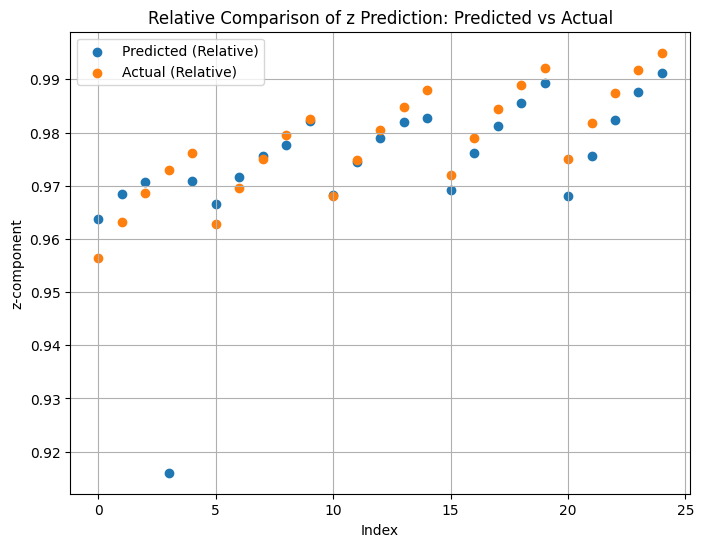

In [374]:
rel_locactz = [x-locact[0,2] for x in locact[:,2]]
rel_loc_predz = [x - loc_pred[0,2] for x in loc_pred[:,2]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(angle_pred[:,2]))), angle_pred[:,2], label='Predicted (Relative)')
plt.scatter(list(range(len(actang[:,2]))), actang[:,2], label='Actual (Relative)')
plt.xlabel('Index')
plt.ylabel('z-component')
plt.title('Relative Comparison of z Prediction: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()